In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   
    
def find_object_centers(image):
    # Load the image
    #image = cv2.imread(image_path)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    l_b = np.array([0, 0, 0])  # Lower bound for black color
    u_b = np.array([255, 255, 36])  # Upper bound for black color

    # Create a Mask with adaptive threshold
    mask = cv2.inRange(hsv, l_b, u_b)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    denoised = cv2.medianBlur(closing, 5)

    # Find contours
    contours, hierarchy = cv2.findContours(denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter and sort contours by area
    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 2000 < area < 5000:
            filtered_contours.append(cnt)
    filtered_contours.sort(key=cv2.contourArea, reverse=True)

    # Get rectangles bounding the 8 largest contours and retrieve their centers
    objects_contours = filtered_contours[:8]
    center_points = []
    for i, cnt in enumerate(objects_contours):
        x, y, w, h = cv2.boundingRect(cnt)
        center_x = x + w // 2
        center_y = y + h // 2
        center_points.append((center_x, center_y))

    return center_points


In [3]:
image = cv2.imread('images/a(1).jpg')
#Get the centers point
centers = find_object_centers(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)


(1239, 2048, 3)


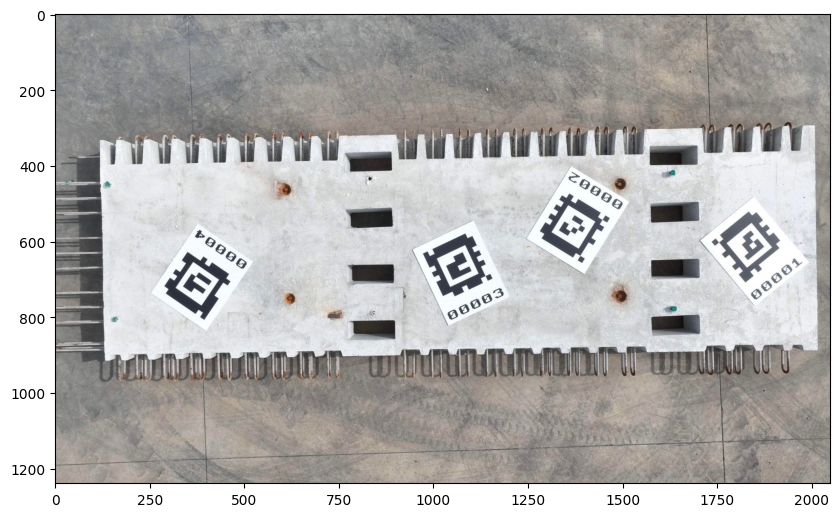

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

# Selecting Imange with SAM

In [5]:
check_point = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor,SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "default"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [7]:
predictor.set_image(image)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 7.79 GiB total capacity; 4.60 GiB already allocated; 372.88 MiB free; 5.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
#checkpoint1
input_point = np.array([[centers[0][0],centers[0][1]]])
input_label = np.array([1])
#checkpoint 2
input_point1 = np.array([[centers[1][0],centers[1][1]]])
input_label1 = np.array([1])
#checkpoint3
input_point2 = np.array([[centers[2][0],centers[2][1]]])
input_label2 = np.array([1])

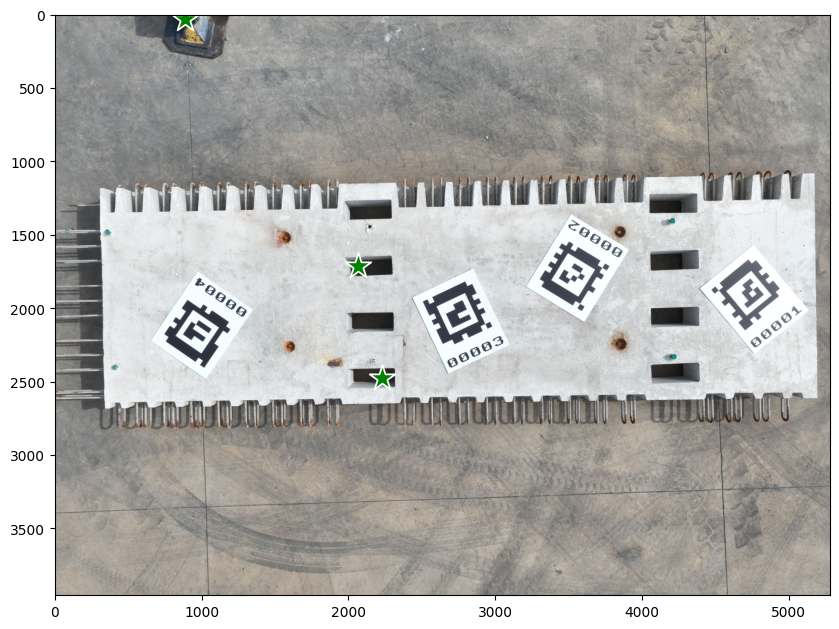

(3956, 5280, 3)

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
show_points(input_point1, input_label1, plt.gca())
show_points(input_point2, input_label2, plt.gca())

plt.axis('on')
plt.show() 
image.shape

In [11]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

masks1, scores1, logits1 = predictor.predict(
    point_coords=input_point1,
    point_labels=input_label1,
    multimask_output=True,
)

masks2, scores2, logits2 = predictor.predict(
    point_coords=input_point2,
    point_labels=input_label2,
    multimask_output=True,
)

In [12]:
masks.shape  # (number_of_masks) x H x W

(3, 3956, 5280)

In [13]:
masks1.shape  # (number_of_masks) x H x W

(3, 3956, 5280)

In [14]:
masks2.shape  # (number_of_masks) x H x W

(3, 3956, 5280)

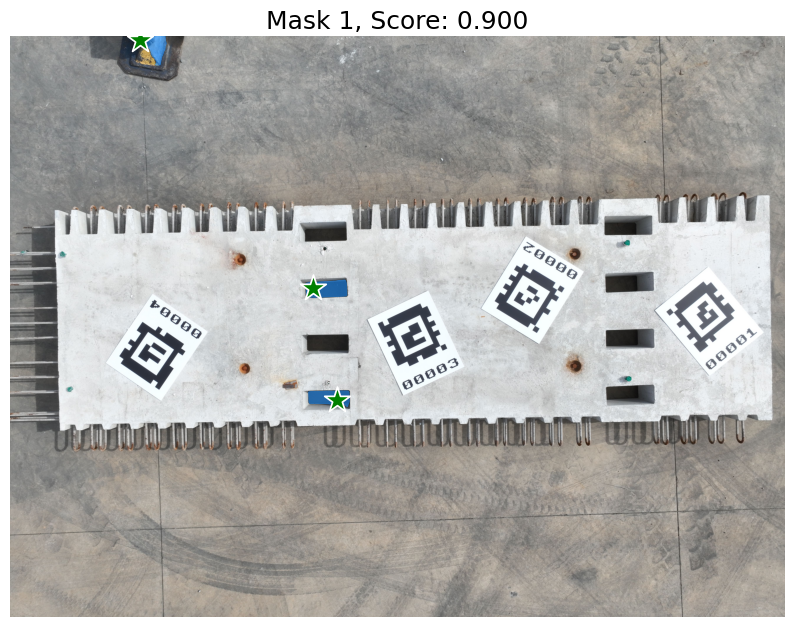

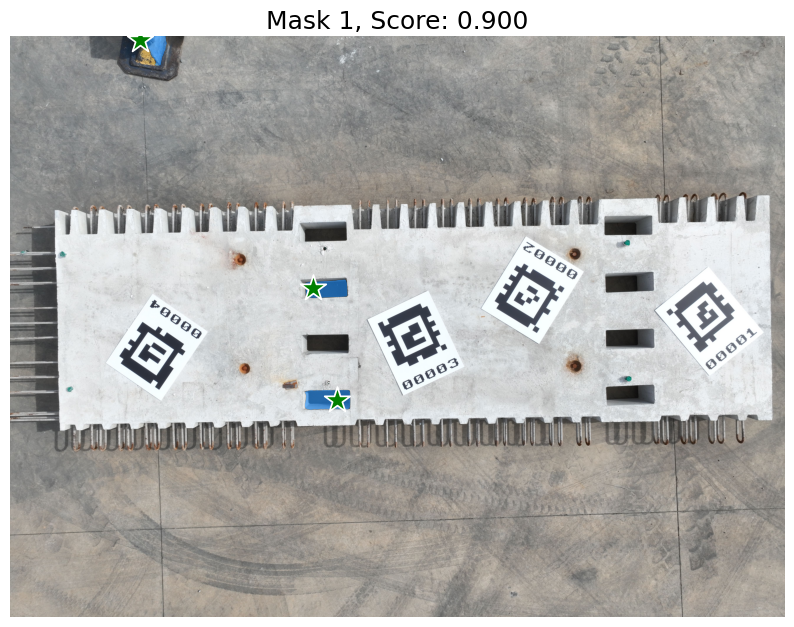

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    for k, (mask1, score1) in enumerate(zip(masks1, scores1)):
        for k, (mask2, score2) in enumerate(zip(masks2, scores2)):

            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_mask(mask, plt.gca())
            show_points(input_point, input_label, plt.gca())
            show_mask(mask1, plt.gca())
            show_points(input_point1, input_label1, plt.gca())

            show_mask(mask2, plt.gca())
            show_points(input_point2, input_label2, plt.gca())
            scorea = (score + score1)/2
            plt.title(f"Mask {i+1}, Score: {scorea:.3f}", fontsize=18)
            plt.axis('off')
            plt.show()    
    

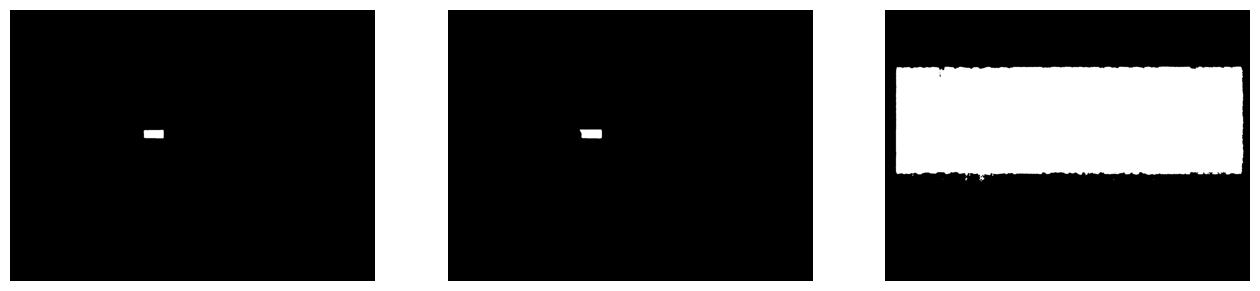

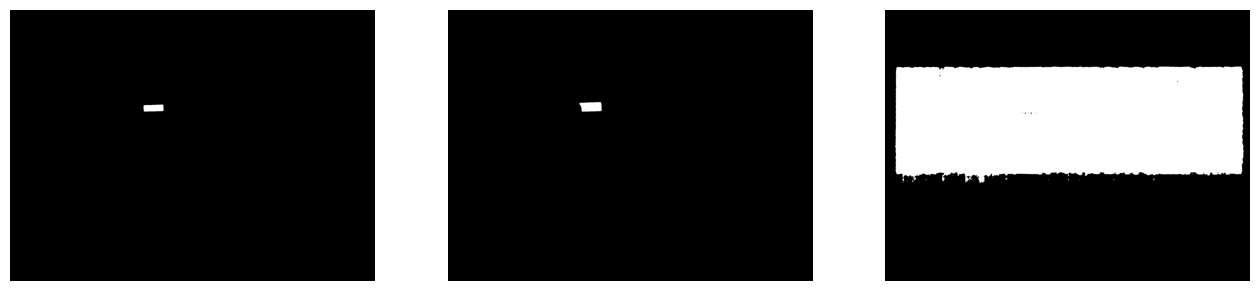

In [15]:
import supervision as sv

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 3),
    size=(16, 4)
)

sv.plot_images_grid(
    images=masks1,
    grid_size=(1, 3),
    size=(16, 4)
)


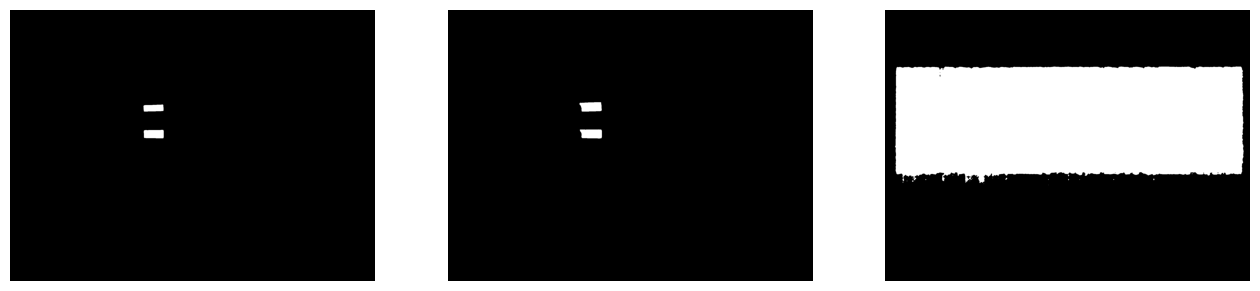

In [16]:
import supervision as sv
sv.plot_images_grid(
    images=masks1 + masks,
    grid_size=(1, 3),
    size=(16, 4)
)

## Show a Single Mask 

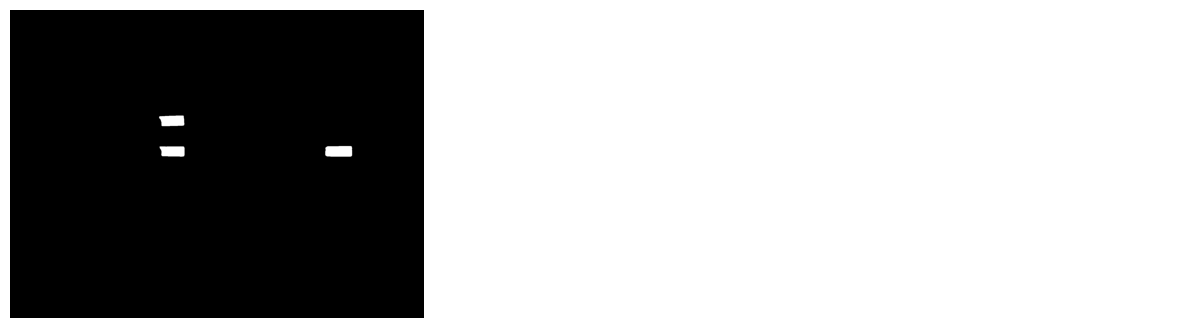

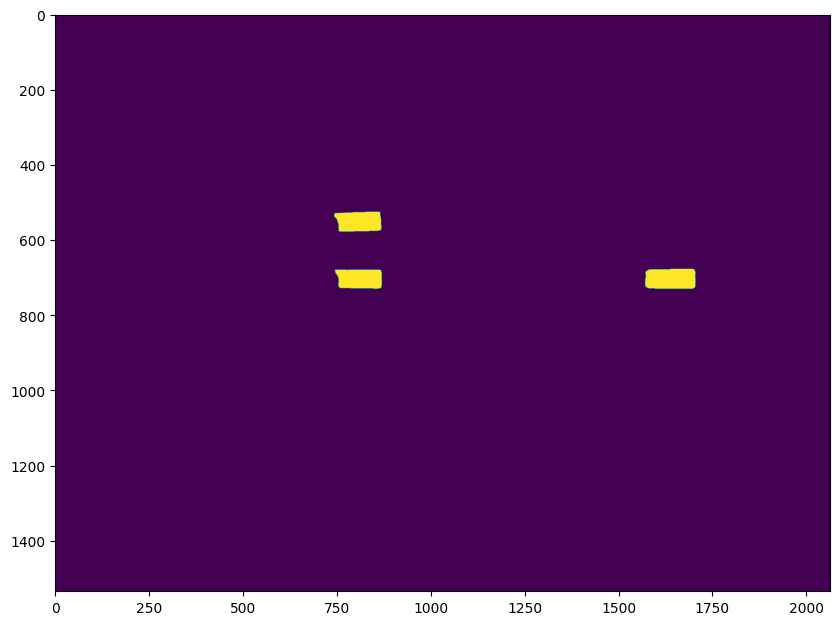

In [18]:
import supervision as sv
import cv2
import numpy as np
import matplotlib.pyplot as plt

mask_index = 1
resized_mask = cv2.resize(masks[mask_index].astype(np.uint8), (2063, 1535))
original_mask = masks[1].astype(np.uint8)  # Convert to uint8

resized_mask1 = cv2.resize(masks1[mask_index].astype(np.uint8), (2063, 1535))
original_mask1 = masks1[1].astype(np.uint8)  # Convert to uint8

resized_mask2 = cv2.resize(masks2[mask_index].astype(np.uint8), (2063, 1535))
original_mask2 = masks2[1].astype(np.uint8)  # Convert to uint8

resized_maskA = resized_mask + resized_mask1 + resized_mask2

sv.plot_images_grid(
    images=np.asarray([resized_maskA]),
    grid_size=(1, 2),
    size=(16, 4)
)

plt.figure(figsize=(10, 10))
plt.imshow(resized_maskA)

cv2.imwrite("lll.jpg", resized_maskA*255)
plt.show()